# Predicting Enron Spam Emails using Supervised Learning

## DS-GA 1001: Introduction to Data Science Final Project

### Scripts

## Models

## Logstic Regression with Elastic Net

Created On: 11/30/2020

Modified On: 12/04/2020

### Description

This script establishes various supervised learning models for the `emails_cleaned.csv` dataset.

### Data

We applied feature engineering to make the data ready for models.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

print("SUCCESS! All modules have been imported.")

SUCCESS! All modules have been imported.


In [2]:
df = pd.read_csv('../data/emails_cleaned.csv')

In [3]:
# Remove rows containing missing values
df.dropna(subset=['X'], inplace=True)
# Confirm that there is no missing values
df.isnull().sum()

X    0
y    0
dtype: int64

In [4]:
df.shape
print('The model-ready dataset contains {} rows.'.format(df.shape[0]))

The model-ready dataset contains 785579 rows.


### Feature Engineering

We applied [Term frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (TF-IDF) method to transform string email contents into meaningful numeric figures so that they can be applied for model training.

#### TF-IDF

In [5]:
# Create a vectorization matrix using tf-idf vectorizer
vectorizer = TfidfVectorizer()
vectorized_emails = vectorizer.fit_transform(df.X)
vectorized_emails

<785579x143084 sparse matrix of type '<class 'numpy.float64'>'
	with 4292928 stored elements in Compressed Sparse Row format>

### Methods

#### Train Test Split

Before fitting the model, we splitted the dataset into two parts: train set and test set. We used train set to train models and used test set to examine the performance of each model.

In [6]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(vectorized_emails, df.y, test_size=test_size, random_state=88)

#### Cross Validation

We applied cross validation to improve model performance.

#### Grid Search

We also applied grid search with to tune the hyperparameters. The goal is to find the optimal hyperparameter `C` so that our model will reach the optimal complexity. 

### Logstic Regression with Elastic Net (Baseline)

We used logistic regression as our baseline model. We also applied elastic net to weight coefficients and added a penalty term to our model. 

##### Elastic Net

We first applied grid search on the parameter of the elastic net, `l1 ratio`. We created a hyperparameter space that contains 30 possible l1 ratio values. We then fitted the training data with 5-fold cross validation to get the best l1 ratio. 

In [16]:
# Setup a hyperparameter grid for l1_ratio that is from 0 to 1
l1_space = [0.2, 0.5, 0.8]
param_grid = {'l1_ratio': l1_space}

In [18]:
elastic_net = ElasticNet()

In [19]:
# Setup the grid search and fit the training data
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5, n_jobs=-1)
gm_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'l1_ratio': [0.2, 0.5, 0.8]})

In [20]:
# Predict on the test dataset and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.2}
Tuned ElasticNet R squared: -9.747972842921726e-06
Tuned ElasticNet MSE: 0.2497127785371497


#### Regularization Strength

We also considered tuning the regularization parameter, `C`. A large `C` leads to overfit while a small `C` can get to underfit. In this case, we set the parameter to 1.

In [7]:
# Setup a hyperparameter grid for C that is from 0 to 1
# param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

In [7]:
# Fit a logistic regression model with elastic net and built-in cross validation
logreg = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.2, max_iter=5000, verbose=0.2)

In [8]:
# logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')
logreg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 25 epochs took 3474 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 57.9min finished


LogisticRegression(l1_ratio=0.2, max_iter=5000, penalty='elasticnet',
                   solver='saga', verbose=0.2)

In [24]:
# best_params_logreg = logreg_cv.best_params_
# validation_auc_logreg = logreg_cv.best_score_
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
test_auc_logreg = roc_auc_score(y_test, y_pred_prob)
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_pred_prob)

In [23]:
# logreg_cv.best_estimator_

In [20]:
print('Tuned Logstic Regression Test AUC: {}'.format(test_auc_logreg))

Tuned Logstic Regression Test AUC: 0.9599844916065247


In [18]:
fpr_logreg = pd.DataFrame(fpr_logreg)
tpr_logreg = pd.DataFrame(tpr_logreg)

In [19]:
fpr_logreg.to_csv('../fpr.logreg.csv')
tpr_logreg.to_csv('../tpr.logreg.csv')

In [21]:
print(confusion_matrix(y_test, y_pred))

[[71599  9633]
 [ 7016 68868]]


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     81232
           1       0.88      0.91      0.89     75884

    accuracy                           0.89    157116
   macro avg       0.89      0.89      0.89    157116
weighted avg       0.89      0.89      0.89    157116



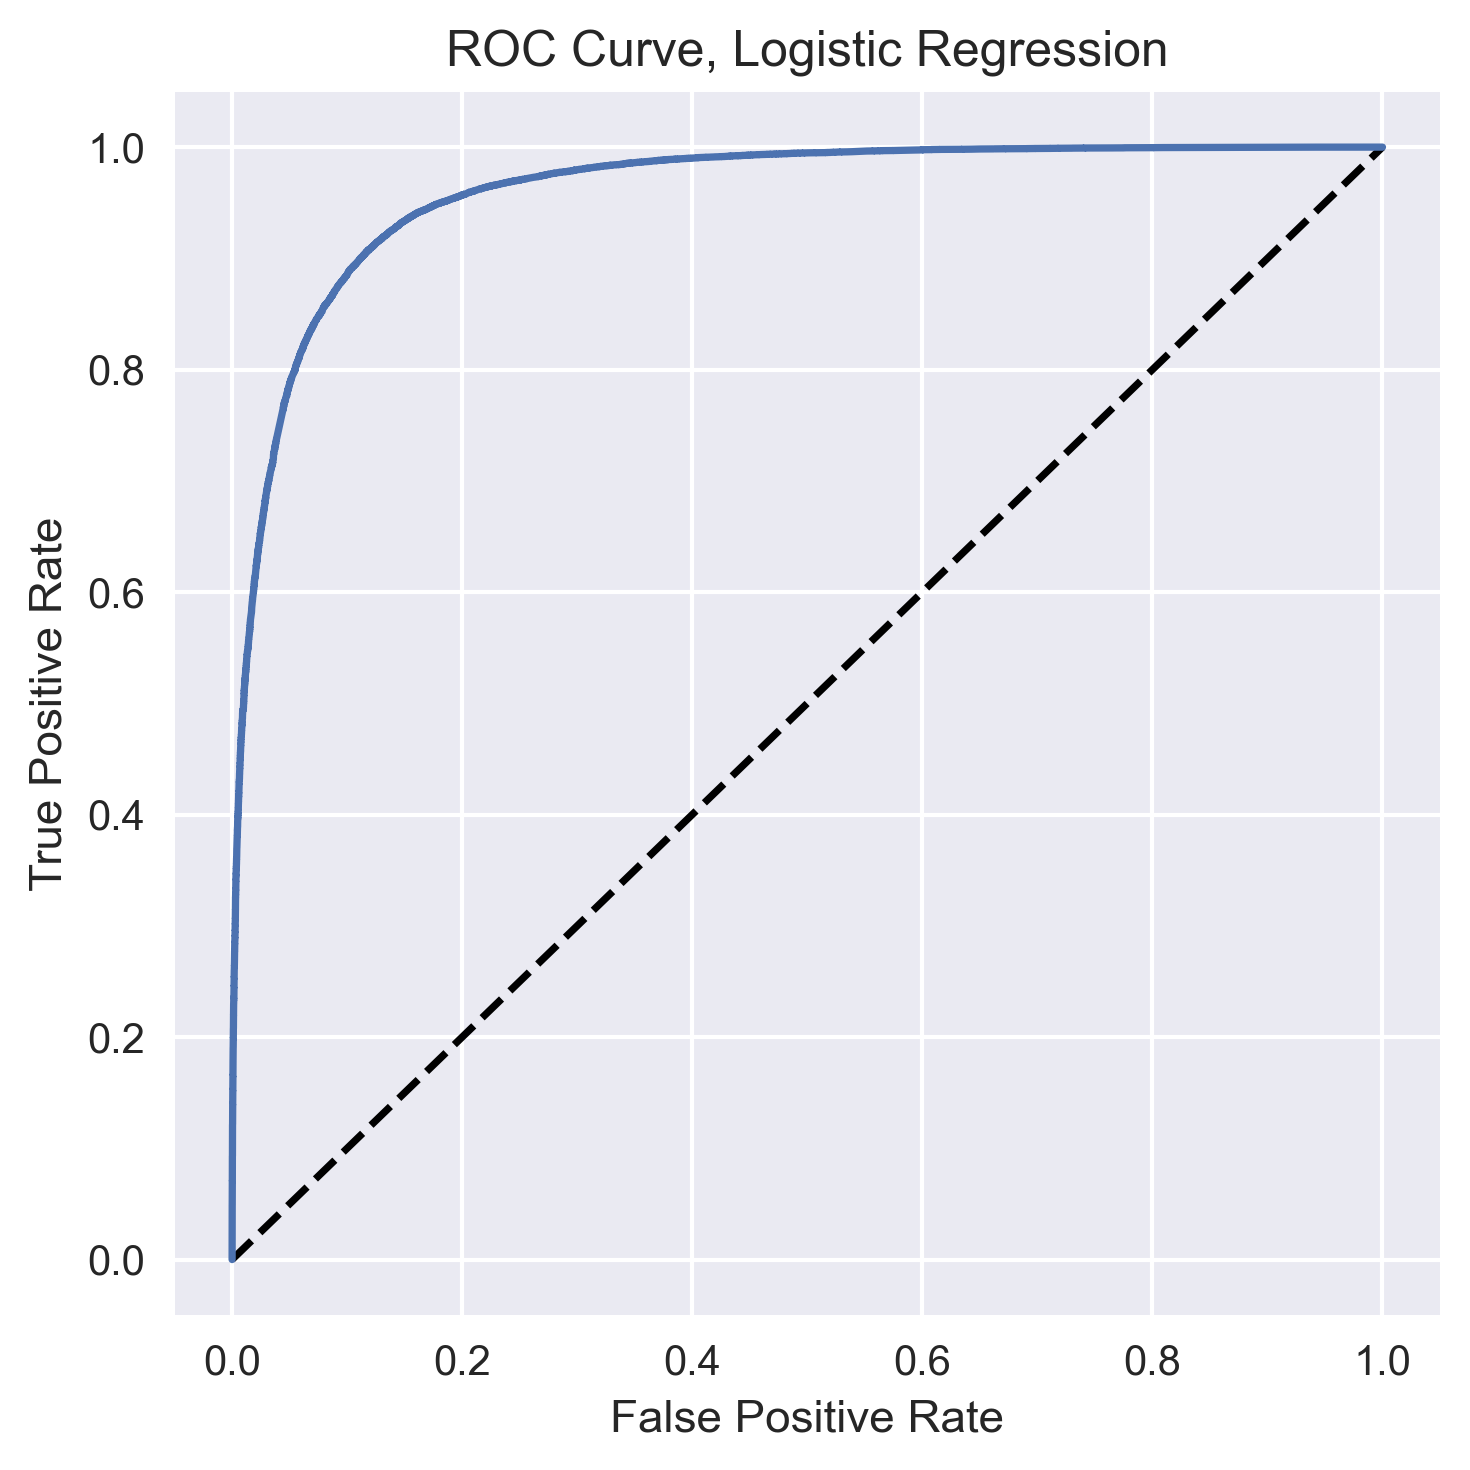

In [25]:
plt.style.use('seaborn')
fig = plt.figure(num=None, figsize=(5, 5), dpi=300, tight_layout=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logreg, tpr_logreg)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, Logistic Regression')
plt.show()
fig.savefig('../results/roc_curve_logistic_regression.png', dpi=fig.dpi)